In [1]:
%cd PathNNs_expressive/TUDatasets

/home/s223188874/PathNNs_expressive/TUDatasets


In [12]:
from model import PathNN
from utils import load_data, PathDataset
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools

### Load model and Data

IMDB-MULTI:
- **Type**: Graph classification dataset based on movie collaborations.
- **Graphs**: Each graph is an ego-network centered around an actor/actress.
- **Nodes**: Represent individual actors/actresses.
- **Edges**: Represent co-appearances between actors in the same movie.
- **Genres**: Focuses on three genres—Comedy, Romance, and Sci-Fi.
- **Labeling**: Each ego-network is labeled according to the genre that predominantly represents the movies where the actor and their co-stars appeared together.
- **Task**: The objective is to classify these ego-networks by their correct genre.
- **Challenge**: The dataset presents a multi-class classification problem, requiring models to distinguish between three different genres based on collaboration patterns.
- **Usage**: Commonly used in machine learning research, particularly for evaluating the performance of graph neural networks (GNNs) and other graph-based models.

Paper replication result:

| Model       | Paper       | Replicated      |
|----------------|----------------|----------------|
| PathNN-SP (K=1)| 50.8 ± 4.5| 49.9 +- 4.2|
| PathNN-SP (K=2)| 50.0 ± 4.1| **51.0 +- 4.6** |
| PathNN-SP (K=3)| OOM | OOM |
| UGformer |  89.20 ± 2.52 | - |

In [3]:
cutoff=2
path_type='shortest_path'

In [4]:
 Gs, features, y, splits = load_data(
    'IMDB-MULTI', 
    use_node_labels=False, 
    use_node_attributes=False, 
    degree_as_tag=True
)
    
dataset = PathDataset(Gs, features, y, cutoff=cutoff, path_type=path_type)

In [5]:
features_dim = features[0].shape[1]
n_classes = len(np.unique(y))


model = PathNN(
    input_dim=features_dim,
    hidden_dim=32,
    cutoff=cutoff,
    n_classes=n_classes,
    dropout=0.5,
    device='cuda:0',
    residuals = True, 
    encode_distances=False
).to('cuda:0')

checkpoint = torch.load('models/IMDB-MULTI/model_best_cutoff_2_path_shortest_path_bs_32_residuals_2024-08-13-14.56.40.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### Visualize Graphs & Metrics

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.average_shortest_path_length.html#networkx.algorithms.shortest_paths.generic.average_shortest_path_length

- **Node Connectivity**: Minimum number of nodes that need to be removed to disconnect the graph (calculated only if the graph is connected).
- **Diameter**: Maximum shortest path length between any pair of nodes in the graph (calculated only if the graph is connected).
- **Degree Assortativity Coefficient**: Correlation between the degrees of connected nodes.
- **Average Neighbor Degree**: Average degree of neighboring nodes for each node in the graph.
- **Average Degree Connectivity**: Average degree of nodes with a given degree.
- **Has Bridges**: Indicates if the graph contains any bridges (edges whose removal increases the number of connected components).
- **Triangles**: Number of triangles (3-cycles) for each node in the graph.
- **Transitivity**: Ratio of the number of triangles to the number of connected triples in the graph (global clustering coefficient).
- **Average Clustering**: Average local clustering coefficient across all nodes in the graph.
- **Is Connected**: Checks if the graph is connected (path exists between every pair of nodes).
- **Number of Connected Components**: Number of connected components (subgraphs where any two vertices are connected) in the graph.
- **Is Strongly Connected**: Checks if the graph is strongly connected (directed path from any node to every other node, for directed graphs only).
- **Number of Attracting Components**: Number of attracting components in a directed graph (subgraphs where every node can reach every other node within the subgraph).
- **Average Shortest Path Length**: Average shortest path length between all pairs of nodes in the graph (calculated only if the graph is connected).

In [6]:
loader = DataLoader(dataset, batch_size = 32, shuffle = False)

In [7]:
preds = []
model.eval()

with torch.no_grad():
    for idx, data in enumerate(loader):
        data = data.to('cuda:0')
        output = model(data)
        pred = output.argmax(dim=1).cpu()
        preds.append(pred)

preds = torch.cat(preds, dim=0)

In [10]:
len(graph_stats)

1500

In [8]:
graph_stats = {}

for i, graph in enumerate(Gs):
    stats = {}
    
    # Calculate the required statistics
    stats['node_connectivity'] = nx.node_connectivity(graph) if nx.is_connected(graph) else None
    stats['diameter'] = nx.diameter(graph) if nx.is_connected(graph) else None
    stats['degree_assortativity_coefficient'] = nx.degree_assortativity_coefficient(graph)
    stats['average_neighbor_degree'] = nx.average_neighbor_degree(graph)
    stats['average_degree_connectivity'] = nx.average_degree_connectivity(graph)
    stats['has_bridges'] = nx.has_bridges(graph)
    stats['triangles'] = nx.triangles(graph)
    stats['transitivity'] = nx.transitivity(graph)
    stats['average_clustering'] = nx.average_clustering(graph)
    stats['is_connected'] = nx.is_connected(graph)
    stats['number_connected_components'] = nx.number_connected_components(graph)
    stats['is_strongly_connected'] = nx.is_strongly_connected(graph) if graph.is_directed() else None
    stats['number_attracting_components'] = nx.number_attracting_components(graph) if graph.is_directed() else None
#     stats['girth'] = nx.cycles.girth(graph) if nx.is_connected(graph) else None
    stats['average_shortest_path_length'] = nx.average_shortest_path_length(graph) if nx.is_connected(graph) else None
    
    # Store the statistics in the dictionary using the graph index as the key
    graph_stats[i] = stats


/opt/python/3.9/anaconda/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


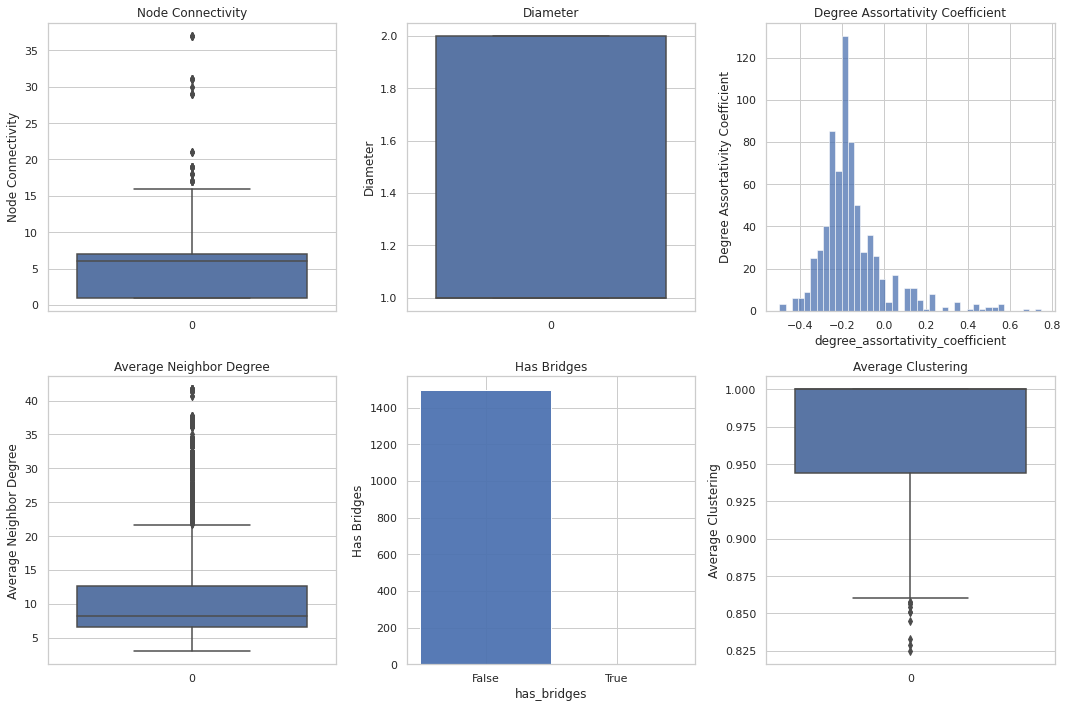

In [27]:
df = pd.DataFrame(graph_stats).transpose()

# Set up the plotting environment
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

plt.subplot(2, 3, 1)
sns.boxplot(data=df['node_connectivity'].dropna())
plt.title('Node Connectivity')
plt.ylabel('Node Connectivity')

plt.subplot(2, 3, 2)
sns.boxplot(data=df['diameter'].dropna())
plt.title('Diameter')
plt.ylabel('Diameter')

plt.subplot(2, 3, 3)
sns.histplot(data=df['degree_assortativity_coefficient'])
plt.title('Degree Assortativity Coefficient')
plt.ylabel('Degree Assortativity Coefficient')

import itertools
plt.subplot(2, 3, 4)
sns.boxplot(data=list(itertools.chain(*df['average_neighbor_degree'].apply(lambda x: list(x.values())))))
plt.title('Average Neighbor Degree')
plt.ylabel('Average Neighbor Degree')

# plt.subplot(2, 3, 5)
# sns.boxplot(data=df['average_degree_connectivity'].dropna())
# plt.title('Average Degree Connectivity')
# plt.ylabel('Average Degree Connectivity')


plt.subplot(2, 3, 5)
sns.histplot(data=df['has_bridges'].astype(str))
plt.title('Has Bridges')
plt.ylabel('Has Bridges')



plt.subplot(2, 3, 6)
sns.boxplot(data=df['average_clustering'].dropna())
plt.title('Average Clustering')
plt.ylabel('Average Clustering')



plt.subplot(2, 3, 5)
sns.histplot(data=df['has_bridges'].astype(str))
plt.title('Has Bridges')
plt.ylabel('Has Bridges')

plt.tight_layout()
plt.show()


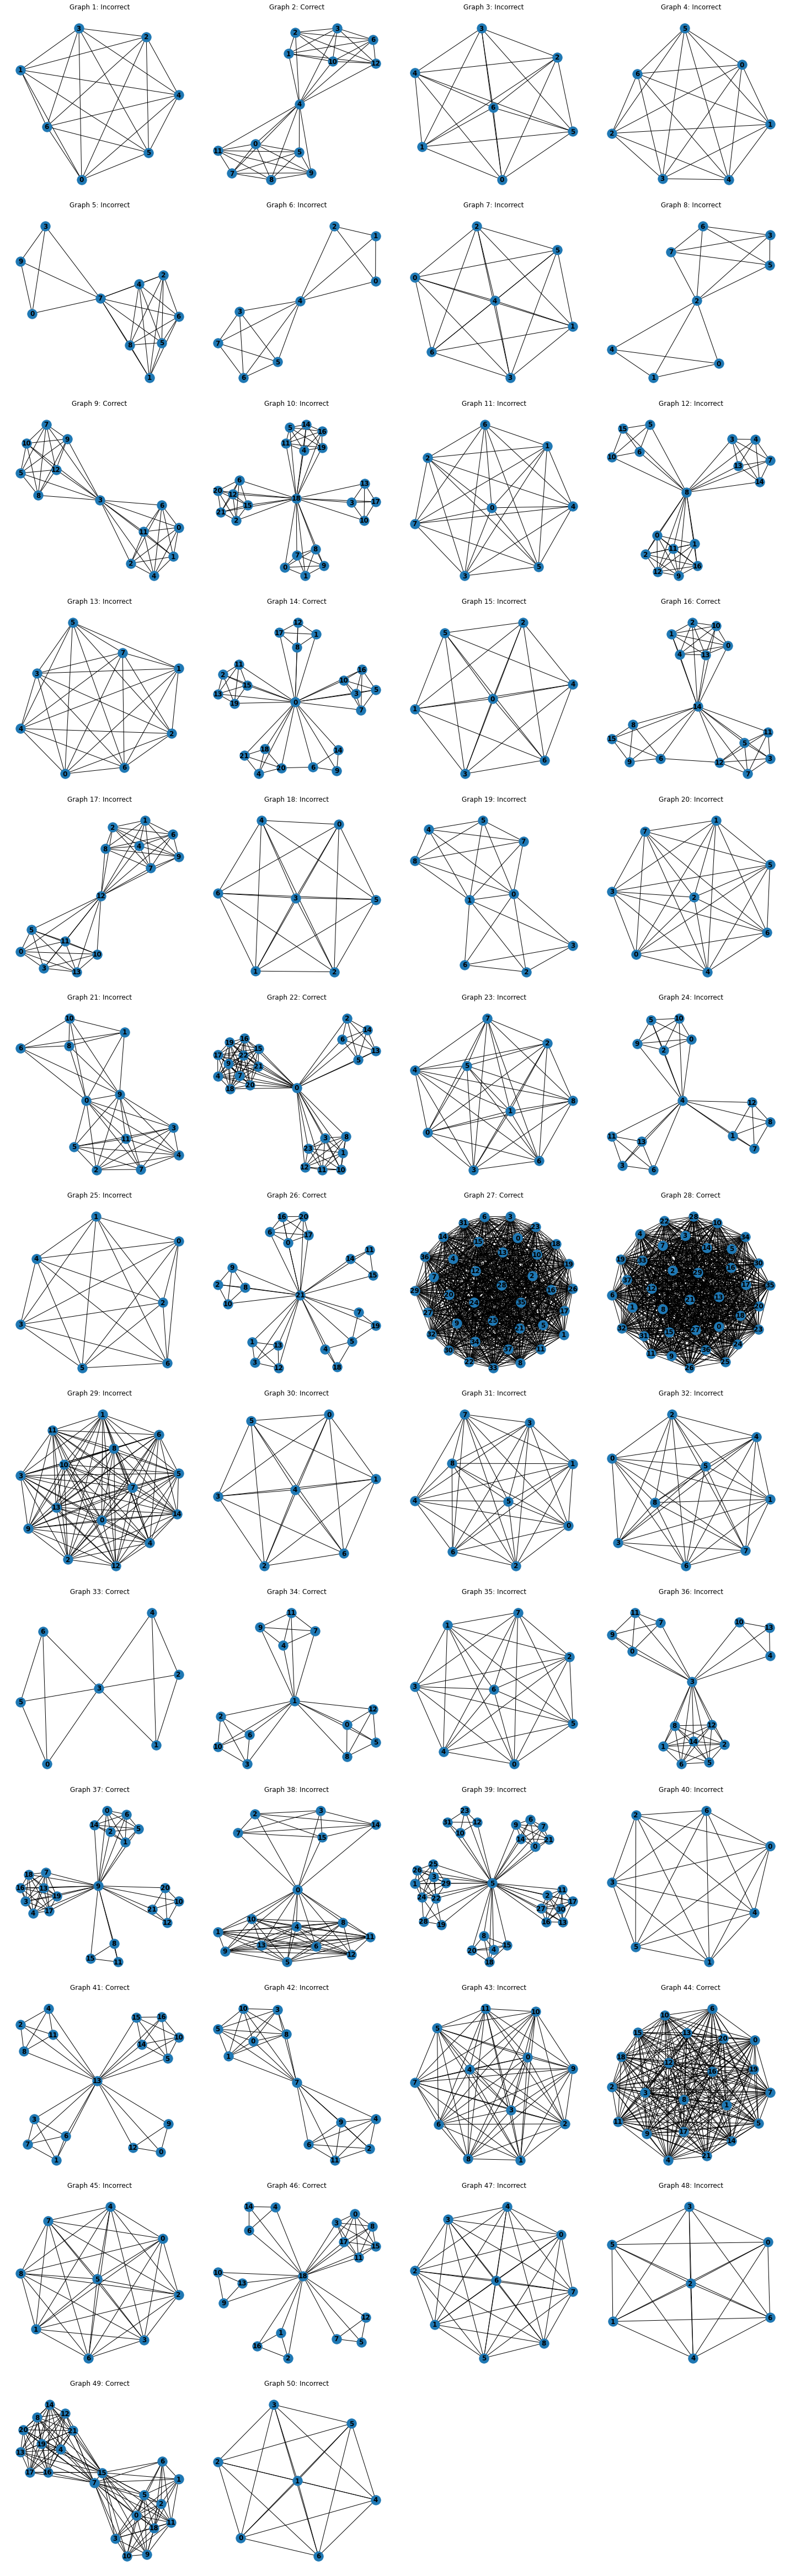

In [92]:
import math 

n=50

cols = min(math.ceil(math.sqrt(n)), 4)
rows = math.ceil(n / cols) 

plt.figure(figsize=(cols * 5, rows * 5))

for i in range(n):
    plt.subplot(rows, cols, i + 1)  # Create subplot in the grid
    nx.draw(Gs[i], with_labels=True, font_weight='bold')  # Draw the graph
    is_correct = preds[i] == y[i]
    title = 'Correct' if is_correct else 'Incorrect'
    plt.title(f'Graph {i+1}: {title}')
    
plt.tight_layout()
plt.show()

### UMAP visualization

In [148]:
!pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 85 kB 246 kB/s eta 0:00:011
     |████████████████████████████████| 56 kB 2.8 MB/s  eta 0:00:01


In [28]:
import torch
import umap
import matplotlib.pyplot as plt

hidden_representations = []

def hook_fn(module, input, output):
    hidden_representations.append(output.cpu().detach())

hook = model.linear1.register_forward_hook(hook_fn)

model.eval()

with torch.no_grad():
    for idx, data in enumerate(loader):
        data = data.to('cuda:0')
        output = model(data)

hook.remove()

hidden_representations = torch.cat(hidden_representations, dim=0)

/home/s223188874/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/python/3.9/anaconda/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/s223188874/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/python/3.9/anaconda/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  war

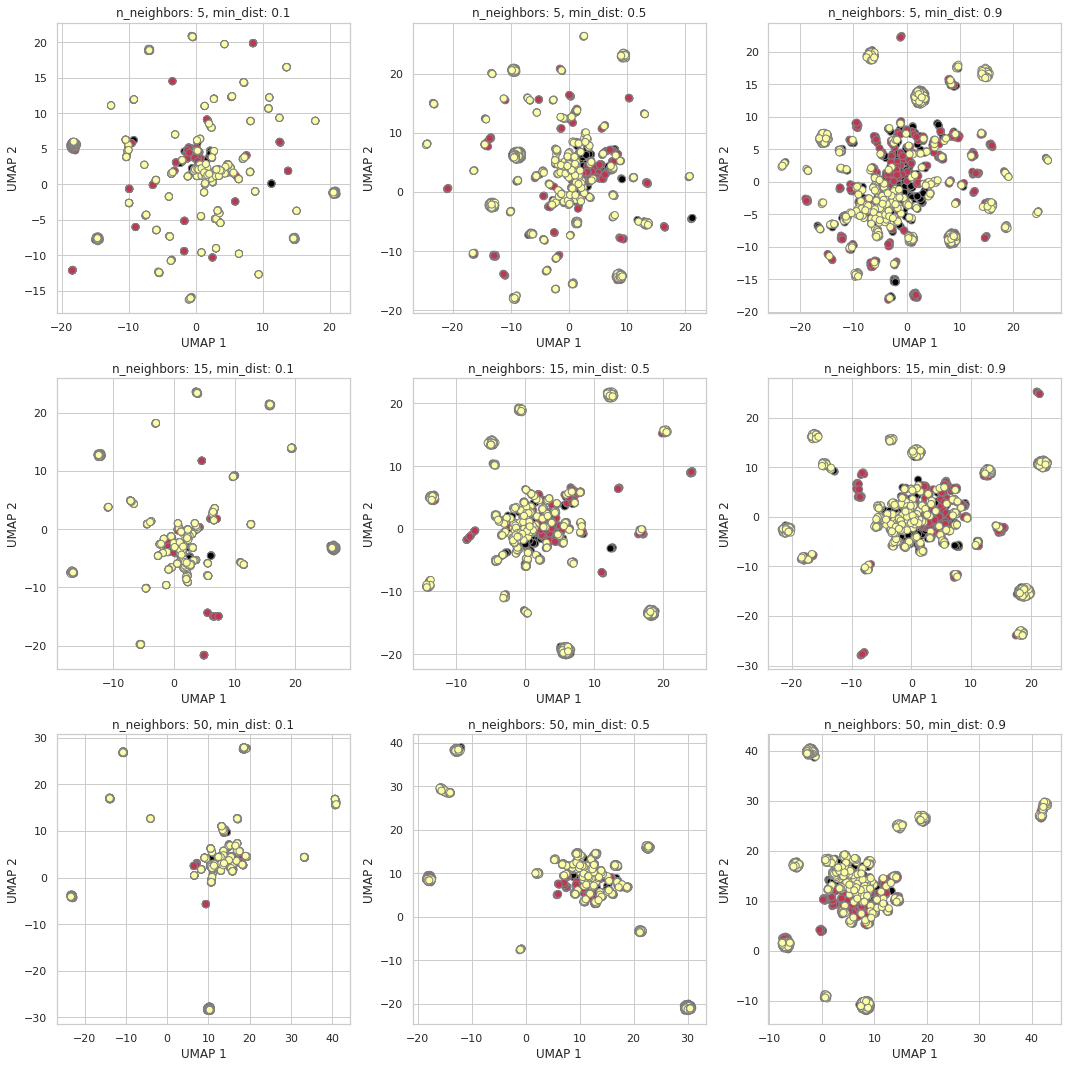

In [39]:
import umap
import matplotlib.pyplot as plt
import numpy as np

n_neighbors_values = [5, 15, 50]
min_dist_values = [0.1, 0.5, 0.9]

fig, axes = plt.subplots(len(n_neighbors_values), len(min_dist_values), figsize=(15, 15))

for i, n_neighbors in enumerate(n_neighbors_values):
    for j, min_dist in enumerate(min_dist_values):
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)
        embedding = reducer.fit_transform(hidden_representations.numpy())

        ax = axes[i, j]
        ax.scatter(embedding[:, 0], embedding[:, 1], c=y, s=50, cmap='inferno', edgecolors='gray')
        ax.set_title(f"n_neighbors: {n_neighbors}, min_dist: {min_dist}")
        ax.set_xlabel("UMAP 1")
        ax.set_ylabel("UMAP 2")

plt.tight_layout()
plt.show()
